# Graph Lab

## Header information:

  - Author #1: Luigi Quattrociocchi (quattrl@mcmaster.ca)
  - Author #2: Dennis Fong (fongd1@mcmaster.ca)
  - Gitlab URL: http://gitlab.cas.mcmaster.ca/quattrl/l1-graph-lab
  - Avenue to Learn group name: Graph 42

## Week 1

In [1]:
# Build a graph from the csv files
from graphlib.builders import TubemapCSVBuilder

tubemap_builder = TubemapCSVBuilder("_dataset/london.stations.csv", "_dataset/london.connections.csv", "_dataset/london.lines.csv")
tubemap_graph = tubemap_builder.build()

In [2]:
# Compute some metrics about the graph
from graphlib.metrics import NumberOfNodesMetric, NumberOfEdgesMetric, DegreeMetric

print(f"Number of nodes = {NumberOfNodesMetric(tubemap_graph)()}")
print(f"Number of edges = {NumberOfEdgesMetric(tubemap_graph)()}")

node_degrees = [DegreeMetric(tubemap_graph, x)() for x in tubemap_graph.adj]
avg_degree = sum(node_degrees) / len(node_degrees)
print(f"Average node degree = {avg_degree}")

Number of nodes = 302
Number of edges = 406
Average node degree = 2.6887417218543046


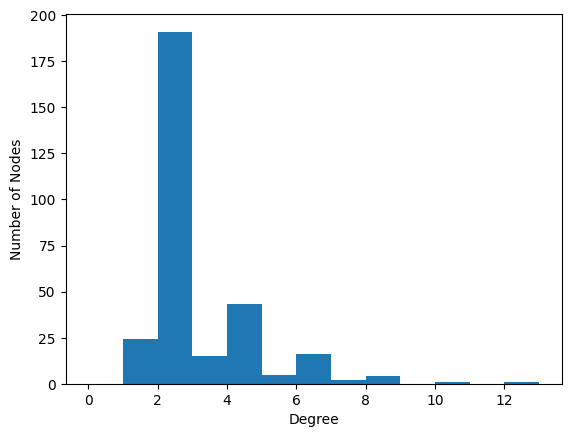

In [3]:
# Draw the distribution of node degrees
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

N = max(node_degrees) + 1
fig, ax = plt.subplots(1, 1)
N, bins, patches = ax.hist(node_degrees, bins=N, range=(0, N))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
_ = plt.xlabel("Degree")
_ = plt.ylabel("Number of Nodes")

Case "Dijkstra-1-1-1-Picadilly_Circus-St._Paul's":
KPI 1: Edges evaluated  = 168
KPI 2: Nodes evaluated  = 40
KPI 3: Edge relaxations = 59
Case "A*-1-1-1-Picadilly_Circus-St._Paul's":
KPI 1: Edges evaluated  = 53
KPI 2: Nodes evaluated  = 12
KPI 3: Edge relaxations = 24
Case "Dijkstra-1-0-0-Picadilly_Circus-St._Paul's":
KPI 1: Edges evaluated  = 145
KPI 2: Nodes evaluated  = 36
KPI 3: Edge relaxations = 55
Case "A*-1-0-0-Picadilly_Circus-St._Paul's":
KPI 1: Edges evaluated  = 57
KPI 2: Nodes evaluated  = 13
KPI 3: Edge relaxations = 22
Case "Dijkstra-1-1-100-Picadilly_Circus-St._Paul's":
KPI 1: Edges evaluated  = 294
KPI 2: Nodes evaluated  = 91
KPI 3: Edge relaxations = 134
Case "A*-1-1-100-Picadilly_Circus-St._Paul's":
KPI 1: Edges evaluated  = 31
KPI 2: Nodes evaluated  = 7
KPI 3: Edge relaxations = 18
Case "Dijkstra-1-1-1-Hammersmith-Stratford":
KPI 1: Edges evaluated  = 680
KPI 2: Nodes evaluated  = 219
KPI 3: Edge relaxations = 234
Case "A*-1-1-1-Hammersmith-Stratford":
KPI 1: Ed

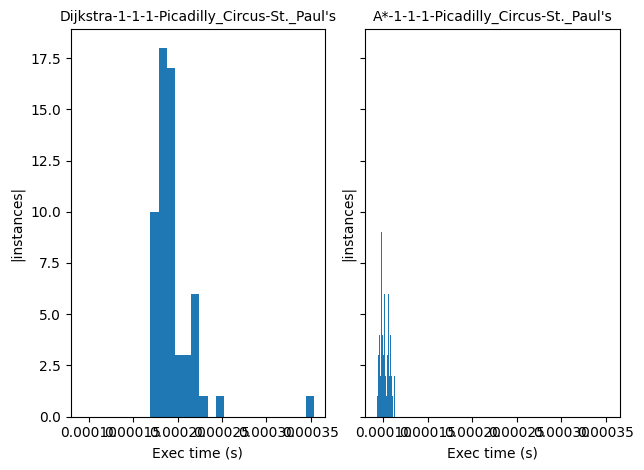

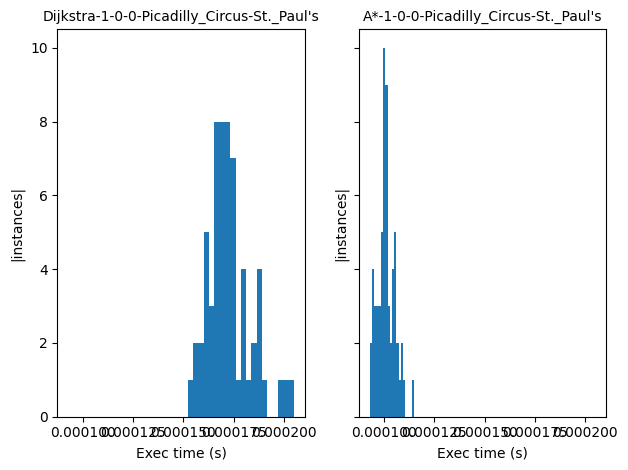

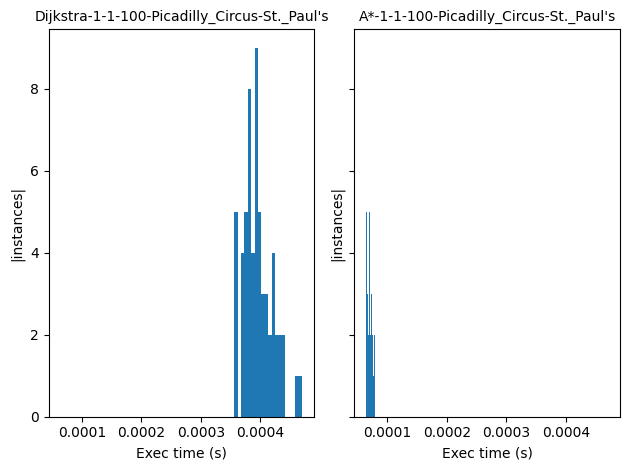

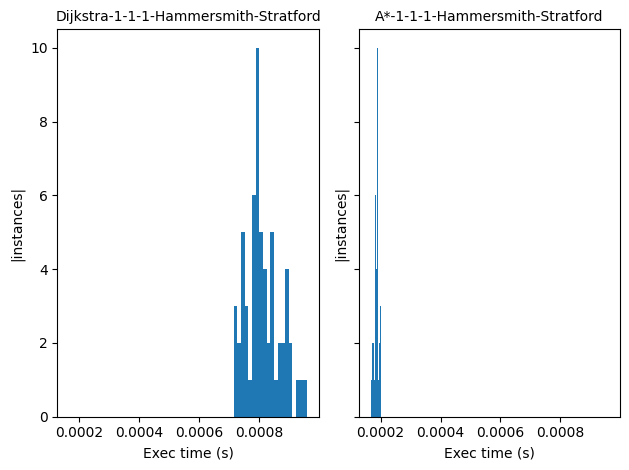

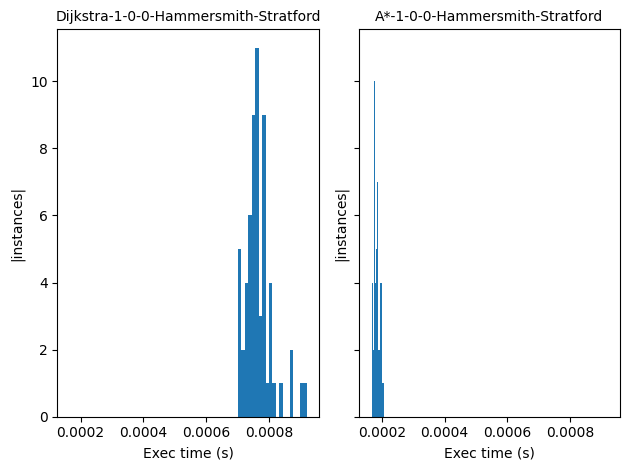

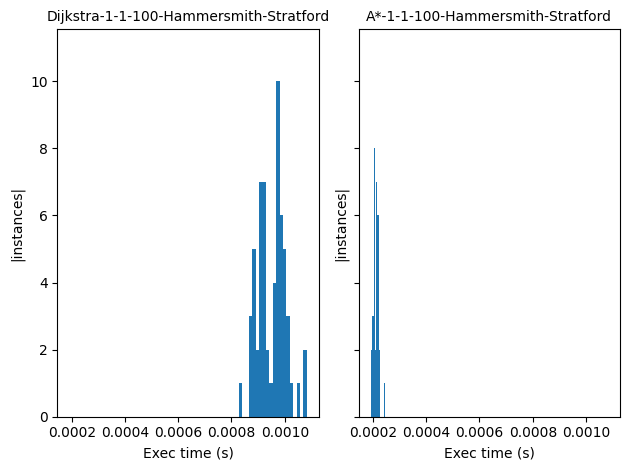

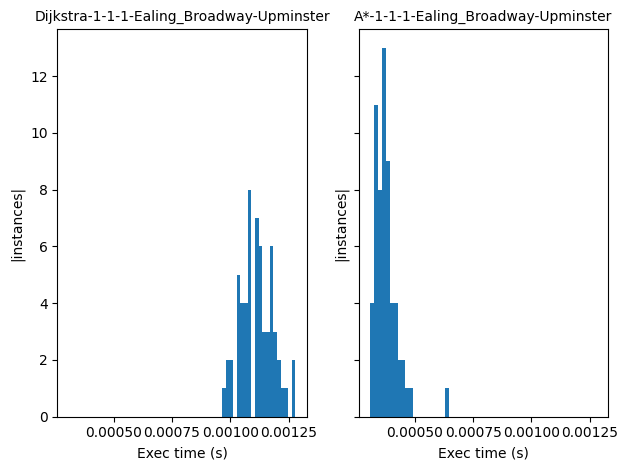

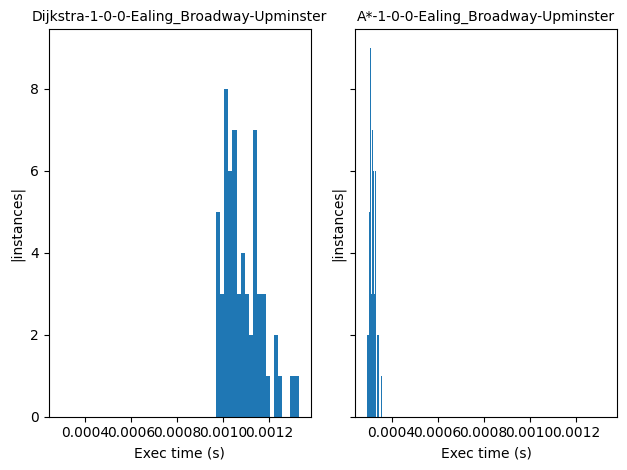

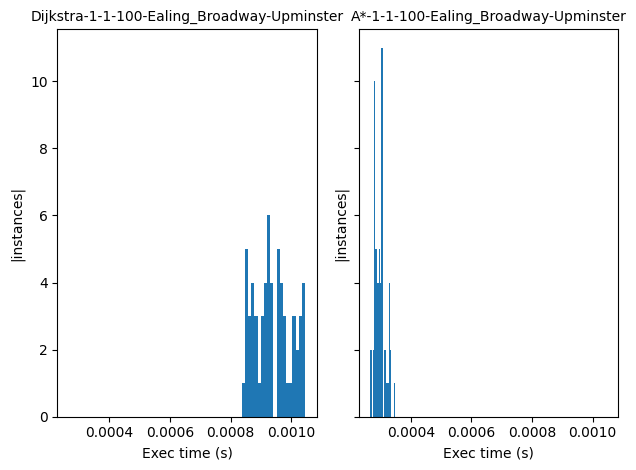

In [4]:
# Run and visualize benchmark
BENCHMARK_FILENAME = "outputs/pyperf_measurements.json"

# Run the benchmark only if a bencmkark results file outputted by pyperf does not exist
import os
if not os.path.exists(BENCHMARK_FILENAME):
    print("Running benchmark. This may take some time, go get a coffee or something...")
    !pipenv run python benchmark.py -o $BENCHMARK_FILENAME

# Print KPIs
from benchmark import london_tubemap_cases
for case in london_tubemap_cases():
    _p = case.func(*case.args)
    print(f'Case "{case.name}":')
    print(f"KPI 1: Edges evaluated  = {case.metric._edges_counter}")
    print(f"KPI 2: Nodes evaluated  = {case.metric._nodes_counter}")
    print(f"KPI 3: Edge relaxations = {case.metric._relaxation_counter}")
    print("=" * 60)

# Draw the results
from pyperf import BenchmarkSuite
benchmarks = BenchmarkSuite.load(BENCHMARK_FILENAME).get_benchmarks()
N = len(benchmarks)
for i in range(N//2):
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
    for j in range(2):
        bench = benchmarks[i*2 + j]
        ax = axs[j]
        ax.set_title(bench.get_name(), fontsize=10)
        ax.set(xlabel="Exec time (s)", ylabel="|instances|")
        ax.hist(bench.get_values(), 20)
    fig.tight_layout()

### Benchmark results analysis
It's clear to see that the A* algorithm has lower average execution times and lower KPIs in every category for every test case (see `benchmark.py` for test cases). This correlation makes sense: if a searching algorithm inspects fewer nodes, edges, and performs less relaxations, then does less work and will finish faster.
  
An important note to make here is the heuristic function used by the particular version of A* benchmarked. The heuristic function used is the Great-circle distance between the latitude and longitude points of the current station and the target station. This is a (mostly) accurate way to measure the distance between two points given their positions on the earth, and for points this close together we could even have used the euclidian distance between the points (essentially projecting the points onto a plane). For the london tubemap data, [neither of these particular heuristics are necessarily admissible](https://en.wikipedia.org/wiki/Admissible_heuristic), and we can see that A* does not always return the "shortest" path by weight. This contributes to the margin of victory of A* over Dijkstra.

### Class diagram
![UML Diagram](./uml/graphlib1.svg)  
Notes: 
- *args and **kwargs are ways to pass a variable number of arguments into a function in python

### Justification of design choices
A couple important design decisions were made this week. Most notably: the separation of "builders" and "graphs", the structure and usage of "graph metrics", and the tubemap itinerary.  
  
The notion of a `BiGraphBuilder` (an abstract base class) was introduced to generalize the production/building of some kind of graph. It is important that this functionality is distinct from the graph class itself to reduce the coupling between the format of the input and the graph, while maintaining cohesion.  
  
The `BiGraphBuilder` has an abstract method called `build`, which takes some (arbitrary) arguments and returns a graph, created from those arguments. In our case, a concrete implemenation of `BiGraphBuilder` called `TubemapCSVBuilder` takes three filenames of .csv files of stations, connections, and lines, and returns a bidirectional graph (`BiGraph`) class from the contents of those files. If a new kind of representation of a graph comes in some other form (different file format, input stream, existing graph, etc), a new subclass of `BiGraphBuilder` can be created. This is similar to the factory design pattern, however having a dedicated builder class is more useful because additional information (perhaps a byproduct of the input used to build the graph) can be stored inside the class, separate from the graph.  
  
The graph metrics, like the graph builders, are entirely distinct from the graph class itself. This way, the SRP (single responsibility principle) is satisfied. Our library has an abstract base class `GraphMetric` which has an abstract `__call__` method. Each "metric" (any information that a user may want to extract from their graph) is implemented as a subclass of `GraphMetric`. To extract a metric, a user should instantiate the subclass of the desired metric and "call" that object. The design of this mechanism is intentional and important for satifying the Open/Closed principle; When a library writer want to add a new metric (extending functionality) without modifying (and potentially breaking) existing code, they should create a new subclass of `GraphMetric`.
  
The `TubemapItinerary` class is yet another practical application of a design pattern in our library. The class uses the strategy pattern to compute an optimal path between two stations. The itinerary class is constructed with the IDs of the starting and target nodes, and has a method `set_search_strategy` which takes a callable object (more specifically, a `PathMetric`, which is an abstract subclass of `GraphMetric`). The `PathMetric` dependency is injected into the itinerary class when it is set, and is called upon later when the itinerary's `shortest_path` method is called. The itinerary class was written in this way for SRP purposes: `TubemapItinerary` does not care about the graph or search strategy implementations, only that it can call back to something when it needs to compute the shortest path. `PathMetric` subclasses must (and do) satisfy the Liskov substitution principle for this to work. `TubemapItinerary` can call any `PathMetric` which implements the abstract `__call__` operator with the correct arguments.


### How we split the work and who did what?
The design and implementation of the library was done by both partners together in person during the first week. We agreed that it is beneficial to work together on one computer in the early stages, so that our rapid prototyping isn't slowed down by version control. On the weekend after the first week, we split up the final tasks; Dennis drew the class diagram and Luigi wrote the benchmark, then we checked each others work.

## Week 2

In [5]:
# Subway Patrol Planning
from graphlib.metrics import TubemapPatrolMetric

import random
stations = random.sample(list(tubemap_graph.adj.keys()), 8)
print("Randomly generated stations:", stations)
print()

time, paths = TubemapPatrolMetric(tubemap_graph, stations)()
print("Minimal round trip time:", time)
print()
for path in paths:
    for edge in path:
        print(f"Connection {edge.fr} - {edge.to} (via line {edge.line}, {edge.time} minutes)")
    print()

Randomly generated stations: [15, 196, 273, 280, 209, 88, 285, 25]

Minimal round trip time: 256

Connection 88 - 256 (via line 2, 2 minutes)
Connection 256 - 68 (via line 2, 3 minutes)
Connection 68 - 158 (via line 2, 2 minutes)
Connection 158 - 37 (via line 2, 3 minutes)
Connection 37 - 301 (via line 2, 3 minutes)
Connection 301 - 241 (via line 2, 2 minutes)
Connection 241 - 230 (via line 2, 2 minutes)
Connection 230 - 154 (via line 2, 2 minutes)
Connection 154 - 153 (via line 2, 3 minutes)
Connection 153 - 247 (via line 2, 2 minutes)
Connection 247 - 289 (via line 7, 3 minutes)
Connection 289 - 200 (via line 4, 2 minutes)
Connection 200 - 270 (via line 4, 2 minutes)
Connection 270 - 78 (via line 4, 2 minutes)
Connection 78 - 15 (via line 4, 4 minutes)

Connection 15 - 78 (via line 4, 4 minutes)
Connection 78 - 270 (via line 4, 2 minutes)
Connection 270 - 200 (via line 4, 2 minutes)
Connection 200 - 289 (via line 4, 2 minutes)
Connection 289 - 36 (via line 4, 2 minutes)
Connection 36

In [6]:
# Tubemap transporation islands
from graphlib.metrics.tubemap_islands import TubemapIslandMetric

components, rep_nodes, zone_edges = TubemapIslandMetric(tubemap_graph)()
named_components = {}
component_names = {}

from math import log, ceil
from itertools import product
from string import ascii_uppercase
num_letters = ceil(log(len(components), 26))
all_names = product(ascii_uppercase, repeat=num_letters)
for rep_node, component in components.items():
    name = "".join(next(all_names))
    named_components[name] = component
    component_names[rep_node] = name

from collections import defaultdict
zone_components = defaultdict(list)

for name, stations in named_components.items():
    zone_components[tubemap_graph.adj[stations[0]].zone].append((name, stations))
for zone, components in sorted(zone_components.items()):
    for name, stations in components:
        print(f"Island {name} (zone {tubemap_graph.adj[stations[0]].zone}):",
              list(map(lambda x: tubemap_builder.station_id_to_name[x], stations)))

for zone_edge in zone_edges:
    print(f"Islands {component_names[rep_nodes[zone_edge.fr]]} (zone {tubemap_graph.adj[zone_edge.fr].zone}), {component_names[rep_nodes[zone_edge.to]]} (zone {tubemap_graph.adj[zone_edge.to].zone})",
          f"connected by {tubemap_builder.station_id_to_name[zone_edge.fr]} - {tubemap_builder.station_id_to_name[zone_edge.to]}",
          f"(on line {zone_edge.line} ({tubemap_builder.line_id_to_name[zone_edge.line]}))")


Island AB (zone 1): ['Aldgate', 'Liverpool Street', 'Bank', "St. Paul's", 'Chancery Lane', 'Holborn', 'Tottenham Court Road', 'Oxford Circus', 'Picadilly Circus', 'Charing Cross', 'Embankment', 'Waterloo', 'Lambeth North', 'Southwark', 'London Bridge', 'Borough', 'Westminster', "St. James's Park", 'Victoria', 'Sloane Square', 'South Kensington', 'Gloucester Road', 'High Street Kensington', 'Knightsbridge', 'Hyde Park Corner', 'Green Park', 'Bond Street', 'Marble Arch', 'Lancaster Gate', 'Queensway', 'Baker Street', 'Marylebone', 'Edgware Road (B)', 'Paddington', 'Bayswater', 'Edgware Road (C)', "Regent's Park", 'Great Portland Street', 'Euston Square', "King's Cross St. Pancras", 'Farringdon', 'Barbican', 'Moorgate', 'Old Street', 'Angel', 'Euston', 'Warren Street', 'Goodge Street', 'Russell Square', 'Pimlico', 'Temple', 'Blackfriars', 'Mansion House', 'Cannon Street', 'Monument', 'Tower Hill', 'Aldgate East', 'Leicester Square', 'Covent Garden']
Island CO (zone 1): ['Tower Gateway']
I

1 0.0019241000000000952
2 0.004382400000000786
3 0.006512400000001861
4 0.007403000000000048
5 0.004388099999999895
6 0.00914500000000018
7 0.007064699999997259
8 0.016079500000000024
9 0.01665450000000135
10 0.028967300000001472
11 0.05651399999999995
12 0.13484820000000042
13 0.33226080000000024
14 0.7088164999999975
15 1.6140989999999995
16 4.835486500000002


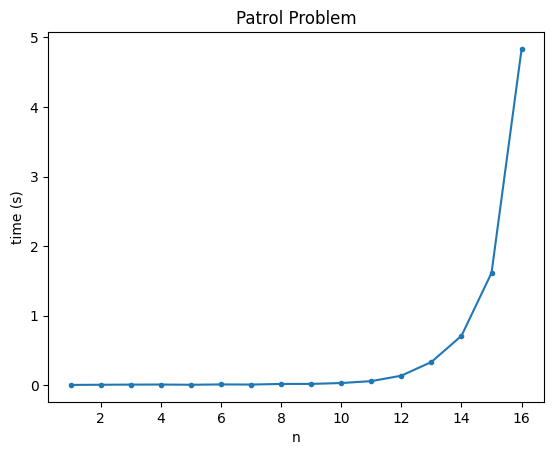

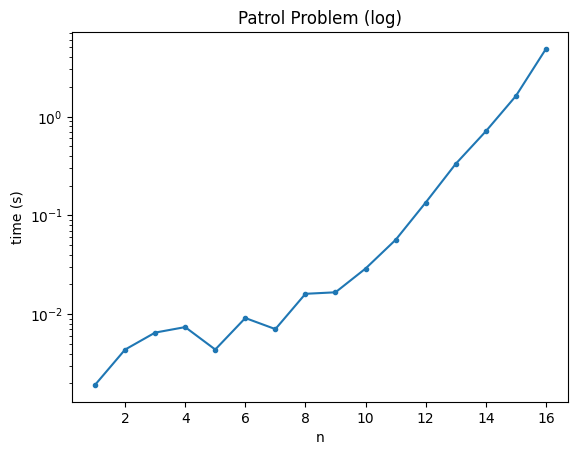

In [8]:
def patrol(tubemap_graph, n):
    stations = random.sample(list(tubemap_graph.adj.keys()), n)
    return TubemapPatrolMetric(tubemap_graph, stations)()

from time import perf_counter
x, y = [], []
for n in range(1, 17):
    t = perf_counter()
    patrol(tubemap_graph, n)
    t = perf_counter() - t
    print(n, t)
    x.append(n)
    y.append(t)

_, ax = plt.subplots(1, 1)
ax.set_title("Patrol Problem")
ax.set(xlabel="n", ylabel="time (s)")
_ = ax.plot(x, y, marker='.')
_, ax = plt.subplots(1, 1)
ax.set_title("Patrol Problem (log)")
ax.set(xlabel="n", ylabel="time (s)")
_ = ax.semilogy(x, y, marker='.')

### Analysis of algorithms
#### Subway Patrol Planning
The Subway Patrol Planning problem is a variation of the travelling salesman problem (TSP), which essentially boils down to solving for the minimum weight Hamiltonian cycle in a connected graph. This is a well known NP-hard problem in computer science. It can be solved non-optimally by heuristic algorithms in polynomial time, but can only be solved optimally in exponential time. We opted for a traditional dynamic programming approach which takes time proportional to $O(2^n)$ (reasoning below) (as opposed to the brute force algorithm, which checks every permutation of nodes in $O(n!)$ time) where $n$ is the number of stations in the path.

Our implementation of the TSP algorithm first computes a matrix of distances from every station to every other station. The details of this are not important, since the time required becomes insignificant compared to the rest of the algorithm, but we used our existing Dijktra's implementation for this. Next, we recursively compute the minimum cost to visit every station in some order, caching the result of every call to avoid recomputation. 

Let $\text{tsp}(u, S)$ be the cost (time) of the trip so far for one recursive call where $S$ is the set of unvisited stations, and $u$ is the current station. Computing one value of $\text{tsp}(u, S)$ requires time proportional to the size of $S$. Since there are $\binom{n}{k}$ subsets of stations each with $k$ stations, computing every recursive call requires time proportional to $\sum_{k=1}^{n} k \binom{n}{k} = n2^{n-1} = O(2^n)$. Finally, the path is reconstructed by backtracking through the recorded best edges in $O(n)$. The only downside of this algorithm over brute force is the memory usage; caching the results of the recursive calls can take up to $O(2^n)$ extra space. In most cases however, this tradeoff is very worth it to make.

Empirically, we can show that our algorithm has a run time proportional to $2^n$ by running our algorithm on inputs with different sizes of $n$ and plotting the results (shown in the above cell). The first plot shows clear exponential growth, and the second semilog plot supports this as evident by the (nearly) straight line, with exception to the variance in runtimes of smaller times.

#### Urbanism Planning
The Urbanism Planning problem involves finding the "transportation islands" (connected components that do not cross zone boundaries) of our tubemap graph. We boiled this problem down to finding all subgraphs (components) in a disconnected graph (forest), where the original graph is disconnected on every edge that crosses between zones. The algorithm we used to solve problem is based on depth-first search (DFS) and has an overall runtime complexity of $O(n)$, where $n$ is the number of stations in the tubemap. To determine the connected components, we run a recursive DFS starting from every station in the graph. Each recursive call to DFS checks if the adjacent station is in the same zone, and only continues to recurse if the both the current station and the adjacent stations are in the same zone, effectively disconnecting the graph across zone boundaries. This allows us to identify the all the components within the same zone in a single search, (which creates a single transportation island). After performing every call to DFS, we reconnect the components (or "supernodes") by re-adding edges which connect stations in different zones. The reason why this algorithm has a runtime complexity of $O(n)$ is because our DFS doesn't revisit any station, i.e. every station is visited exactly **once**.

### Updated class diagram
![UML Diagram](./uml/graphlib2.svg)  

### Justification of design changes
During week 1, we intended to keep the SOLID principles in mind, and designed the library to adhere to these principles. However, initially our design did not follow the Liskov's Substitution princple in one particular class, namely the `TubemapCSVBuilder` class. During week two, we modified the `TubemapCSVBuilder` class to follow the Liskov's Substitution principle by moving the parameters of the `build` method into the `__init__` method. This way the `build` method is identical for all concrete subclasses of the `BiGraphBuilder` class.
  
Aside from this, no major design changes were necessary because we had the foresight to design our library in a modular way from the beginning. For instance, we already satisfied the open-closed (O in SOLID) principle; we were able to **extend** our design and implement new metrics (`TubemapPatrolMetric` and `TubemapIslandMetric`) without **modifying** existing classes. This was possible because of our `GraphMetric` abstract class which each new graph metric must inherit. In a related vein, the single-responsibility (S in SOLID) and dependency inversion (D in SOLID) principles are also satisfied by this design. Each concrete metric class has the single responsibility of computing its own metric, and users of our library can depend upon the `GraphMetric` class' interface rather than concrete metric implementation.  
Incidentally, the `GraphMetric` class had already satisfied the interface segregation (I in SOLID) principle by only having one abstract method. This was because when creating the class we had the single-responsibility principle in mind, and so the single responsibility of each graph metric *is* the only abstract method.
